# 2D-UNet and 3D-UNet Semantic Segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/CurrentData')

In [3]:
import cv2
import torch
import torch.nn as nn
import numpy as np
from blocks import *
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import copy

# Data

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE" -O dataset.npy && rm -rf /tmp/cookies.txt

In [4]:
# dataset_path = '/content/drive/MyDrive/CurrentData/dataset.npy'
dataset_path = '/content/dataset.npy'
labeled_images = np.load(dataset_path, allow_pickle=True)
ORGAN_idx = 6
ORGAN = 'liver'
image_shape = (128, 128)
image_slices = 208

data_X = []
data_Y = []
for idx in range(len(labeled_images)):
    xx = labeled_images[idx].get("image")
    yy = labeled_images[idx].get("label")

    yy[np.where(yy != ORGAN_idx)] = 0
    yy[np.where(yy == ORGAN_idx)] = 1

    x = []
    y = []
    for i in range(len(xx)):
        x.append(cv2.resize(xx[i,:,:], image_shape))
        y.append(cv2.resize(yy[i,:,:], image_shape))
    x = np.asarray(x)
    y = np.asarray(y)

    if x.shape[0] < image_slices:
      diff = image_slices - x.shape[0]
      data_X.append(np.concatenate((x, np.zeros((diff, image_shape[0], image_shape[1]), dtype=np.float32))))
      data_Y.append(np.concatenate((y, np.zeros((diff, image_shape[0], image_shape[1]), dtype=np.float32))))

data_X = np.asarray(data_X)
data_Y = np.asarray(data_Y)
print(data_X.shape)
print(data_Y.shape)

(30, 208, 128, 128)
(30, 208, 128, 128)


In [5]:
n_train, n_valid = 20, 10

train_X = data_X[:n_train]
train_Y = data_Y[:n_train]

valid_X = data_X[n_train:n_train+n_valid]
valid_Y = data_Y[n_train:n_train+n_valid]

print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)

(20, 208, 128, 128) (20, 208, 128, 128)
(10, 208, 128, 128) (10, 208, 128, 128)


Visualizing some of the slices randomly from the dataset

In [ ]:
available_masks = []
for i in range(train_Y.shape[0]):
  for j in range(train_Y.shape[1]):
    mask = train_Y[i, j, :, :]
    if mask.sum() > 400:
      available_masks.append((i, j))

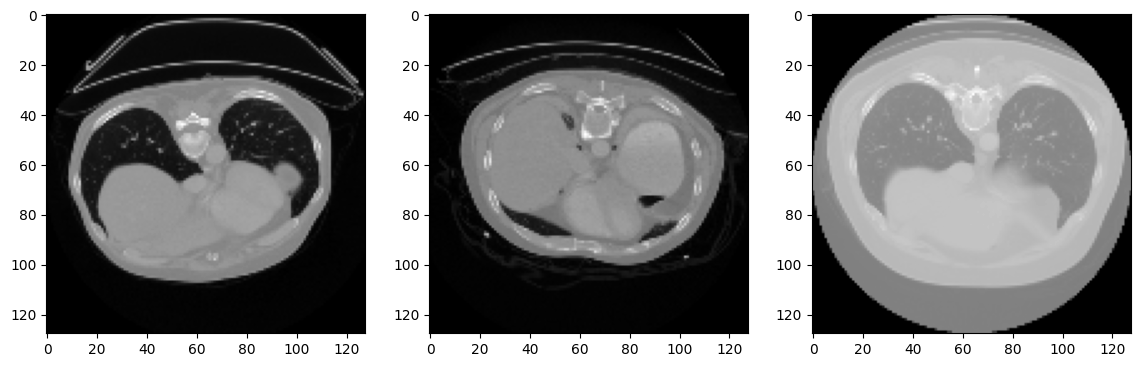

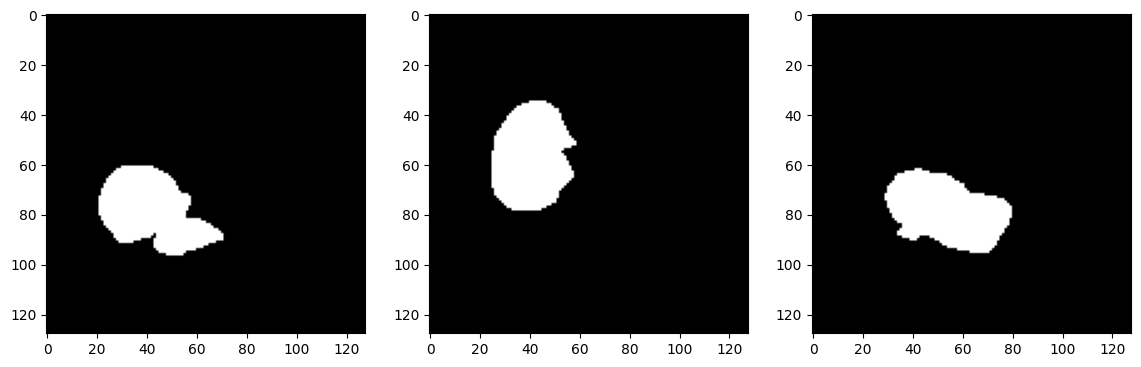

In [ ]:
selected = np.random.randint(0, len(available_masks), 3)

plt.figure(figsize=(14, 16))
plt.subplot(1, 3, 1)
plt.imshow(train_X[available_masks[selected[0]][0], available_masks[selected[0]][1], :, :], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(train_X[available_masks[selected[1]][0], available_masks[selected[1]][1], :, :], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(train_X[available_masks[selected[2]][0], available_masks[selected[2]][1], :, :], cmap='gray')

plt.figure(figsize=(14, 16))
plt.subplot(1, 3, 1)
plt.imshow(train_Y[available_masks[selected[0]][0], available_masks[selected[0]][1], :, :], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(train_Y[available_masks[selected[1]][0], available_masks[selected[1]][1], :, :], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(train_Y[available_masks[selected[2]][0], available_masks[selected[2]][1], :, :], cmap='gray')

# Utils

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def pad_to_shape(this, shp):
    if len(shp) == 4:
        pad = (0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    elif len(shp) == 5:
        pad = (0, shp[4] - this.shape[4], 0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    return F.pad(this, pad)

**Dice Score**

In [8]:
def dice_score(y_pred_bin, y_true):
    """
    Args:
        y_pred_bin: shape => (batch_size, 1, h, w)
        y_true: shape => (batch_size, 1, h, w)

    Returns:
        : shape => (batch_size, dice_score)
    """

    y_pred = nn.Sigmoid()(y_pred_bin).round()

    if len(y_pred.shape) < 5:
      top = 2 *  torch.sum(y_pred * y_true, [1, 2, 3])
      union = torch.sum(y_pred + y_true, [1, 2, 3])
    else:
      top = 2 *  torch.sum(y_pred * y_true, [1, 2, 3, 4])
      union = torch.sum(y_pred + y_true, [1, 2, 3, 4])

    eps = torch.ones_like(union) * 1e-5
    bottom = torch.max(union, eps)
    dice = torch.mean(top / bottom)

    return dice

# Part 1: 2D UNet

## Part 1.1: Model Definition

In [19]:
class UNet2D(nn.Module):

    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'
        super(UNet2D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First2D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder2D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder2D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last2D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center2D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x, return_all=False):

        connections = [x]
        for layer in self.encoder_layers:
            connections.append(layer(connections[-1]))

        x = [self.center(connections[-1])]

        for i, layer in enumerate(self.decoder_layers):
            x_con = connections[-1-i]
            x_cat = torch.cat([pad_to_shape(x[-1], x_con.shape), x_con],
                dim=1)

            x.append(layer(x_cat))

        if not return_all:
            return x[-1]
        else:
            return connections[1:] + x

## Part 1.2: Dataset Definition

In [ ]:
class Dataset2D(Dataset):
    def __init__(self, x, y, Normalization = False):

        self.Normalization = Normalization
        self.slices_x = []
        self.slices_y = []
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                sx = x[i, j, :, :]
                sy = y[i, j, :, :]
                if sy.sum() > 0:
                    self.slices_x.append(sx)
                    self.slices_y.append(sy)

    def __len__(self):
        return len(self.slices_x) # number of samples


    def __getitem__(self, index): # sampling method. used by DataLoader.
        x = self.slices_x[index]
        y = self.slices_y[index]
        if self.Normalization:
            x = (x - x.min()) / (x.max() - x.min())
        return x, y, index # we return the index as well for future use

## Part 1.3: Train

In [ ]:
model = UNet2D(in_channels=1, out_channels=1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
epochs = 50

In [ ]:
train_loader = DataLoader(
    Dataset2D(train_X, train_Y, Normalization=True),
    batch_size=32,
    shuffle=True,
    num_workers=2
)

print('Train Loader Done')

valid_loader = DataLoader(
    Dataset2D(valid_X, valid_Y, Normalization=True),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print('Validation Loader Done')

samples_count = len(train_loader.dataset)
val_samples_count = len(valid_loader.dataset)

dataloaders = {'train': train_loader, 'val': valid_loader}

Train Loader Done
Validation Loader Done


In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50):

  dice_hist = { 'train': [], 'val': [] }
  loss_hist = { 'train': [], 'val': [] }
  best_dice = 0.0
  best_model_wts = None
  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    for phase in ['train', 'val']:
      if phase == 'train':
          model.train()
      else:
          model.eval()
      running_loss = 0.0
      running_dice = 0

      for x, y_true, _ in dataloaders[phase]:
        x = x.unsqueeze(1)
        y_true = y_true.unsqueeze(1)
        x = x.to(device)
        y_true = y_true.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          y_pred = model(x)
          loss = criterion(y_pred, y_true)

          if phase == 'train':
              loss.backward()
              optimizer.step()

        running_loss += loss.mean().item() # Summation of losses
        running_dice += dice_score(y_pred, y_true).item() # Mean of dice scores

      epoch_loss = running_loss / len(dataloaders[phase]) # Average of losses. Use running_loss
      epoch_dice = running_dice / len(dataloaders[phase]) # Average of Dice. Use running_dice

      print(f'{phase} Loss: {epoch_loss:.4f} Dice: {epoch_dice:.4f}')

      if phase == 'val' and epoch_dice > best_dice:
        best_dice = epoch_dice
        best_model_wts = copy.deepcopy(model.state_dict())
      dice_hist[phase].append(epoch_dice)
      loss_hist[phase].append(epoch_loss)

    print()

  print(f'Best val Acc: {best_dice:4f}')

  return best_model_wts, dice_hist, loss_hist

In [ ]:
best_model_wts, dice_hist, loss_hist = train_model(model, dataloaders, nn.BCEWithLogitsLoss(), optimizer, epochs)
# torch.save(best_model_wts, '/content/drive/MyDrive/CurrentData/Seg2D.pt')

Epoch 1/50
----------
train Loss: 0.1839 Dice: 0.0093
val Loss: 4.1491 Dice: 0.0000

Epoch 2/50
----------
train Loss: 0.1110 Dice: 0.0000
val Loss: 0.1318 Dice: 0.0000

Epoch 3/50
----------
train Loss: 0.0941 Dice: 0.3617
val Loss: 0.1146 Dice: 0.5339

Epoch 4/50
----------
train Loss: 0.0860 Dice: 0.5630
val Loss: 0.1157 Dice: 0.4526

Epoch 5/50
----------
train Loss: 0.0807 Dice: 0.5697
val Loss: 0.2300 Dice: 0.1197

Epoch 6/50
----------
train Loss: 0.0718 Dice: 0.5983
val Loss: 0.1200 Dice: 0.4437

Epoch 7/50
----------
train Loss: 0.0702 Dice: 0.6063
val Loss: 0.0910 Dice: 0.5421

Epoch 8/50
----------
train Loss: 0.0671 Dice: 0.6090
val Loss: 0.0951 Dice: 0.6036

Epoch 9/50
----------
train Loss: 0.0563 Dice: 0.6650
val Loss: 0.0887 Dice: 0.5749

Epoch 10/50
----------
train Loss: 0.0578 Dice: 0.6513
val Loss: 0.0701 Dice: 0.6347

Epoch 11/50
----------
train Loss: 0.0563 Dice: 0.6528
val Loss: 0.1203 Dice: 0.5105

Epoch 12/50
----------
train Loss: 0.0459 Dice: 0.7052
val Loss

# Part 2: 3D UNet

Now we want to use a 3D model and see if we can get better results. Complete the specified parts and train the model.

## Part 2.1: Model Definition

In [10]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'

        super(UNet3D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First3D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder3D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder3D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last3D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center3D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x, return_all=False):

        connections = [x]
        for layer in self.encoder_layers:
            connections.append(layer(connections[-1]))

        x = [self.center(connections[-1])]

        for i, layer in enumerate(self.decoder_layers):
            x_con = connections[-1-i]
            x_cat = torch.cat([pad_to_shape(x[-1], x_con.shape), x_con],
                dim=1)

            x.append(layer(x_cat))

        if not return_all:
            return x[-1]
        else:
            return connections[1:] + x

## Part 2.2: Dataset Definition

In [11]:
class Dataset3D(Dataset):
    def __init__(self, x, y, Normalization = False):

        self.Normalization = Normalization
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x) # number of samples


    def __getitem__(self, index): # sampling method. used by DataLoader.
        x = self.x[index]
        y = self.y[index]
        if self.Normalization:
            x = (x - x.min()) / (x.max() - x.min())
        return x, y, index # we return the index as well for future use

## Part 2.3: Train

In [12]:
model_3d = UNet3D(in_channels=1, out_channels=1)
model_3d.to(device)
optimizer = torch.optim.Adam(model_3d.parameters(), lr=1e-3)
epochs = 50

In [13]:
train_loader = DataLoader(
    Dataset3D(train_X, train_Y, Normalization=True),
    batch_size=1,
    shuffle=True,
    num_workers=2
)

print('Train Loader Done')

valid_loader = DataLoader(
    Dataset3D(valid_X, valid_Y, Normalization=True),
    batch_size=1,
    shuffle=False,
    num_workers=2
)

print('Validation Loader Done')

dataloaders = {'train':train_loader, 'val':valid_loader}

Train Loader Done
Validation Loader Done


In [14]:
best_model_wts_3d, dice_hist_3d, loss_hist_3d = train_model(model_3d, dataloaders, nn.BCEWithLogitsLoss(), optimizer, epochs)
# torch.save(best_model_wts_3d, '/content/drive/MyDrive/CurrentData/Seg3D_v2.pt')

Epoch 1/50
----------
train Loss: 0.5653 Dice: 0.0257
val Loss: 0.5003 Dice: 0.0199

Epoch 2/50
----------
train Loss: 0.4653 Dice: 0.0101
val Loss: 0.4347 Dice: 0.0004

Epoch 3/50
----------
train Loss: 0.4036 Dice: 0.0000
val Loss: 0.3815 Dice: 0.0000

Epoch 4/50
----------
train Loss: 0.3587 Dice: 0.0002
val Loss: 0.3407 Dice: 0.0000

Epoch 5/50
----------
train Loss: 0.3102 Dice: 0.0000
val Loss: 0.2827 Dice: 0.0000

Epoch 6/50
----------
train Loss: 0.2609 Dice: 0.0234
val Loss: 0.2377 Dice: 0.0000

Epoch 7/50
----------
train Loss: 0.2216 Dice: 0.0182
val Loss: 0.2050 Dice: 0.0341

Epoch 8/50
----------
train Loss: 0.1916 Dice: 0.1796
val Loss: 0.1772 Dice: 0.0777

Epoch 9/50
----------
train Loss: 0.1654 Dice: 0.4459
val Loss: 0.1552 Dice: 0.5462

Epoch 10/50
----------
train Loss: 0.1443 Dice: 0.6216
val Loss: 0.1328 Dice: 0.7096

Epoch 11/50
----------
train Loss: 0.1249 Dice: 0.7760
val Loss: 0.1195 Dice: 0.4640

Epoch 12/50
----------
train Loss: 0.1100 Dice: 0.7788
val Loss

# Visualization

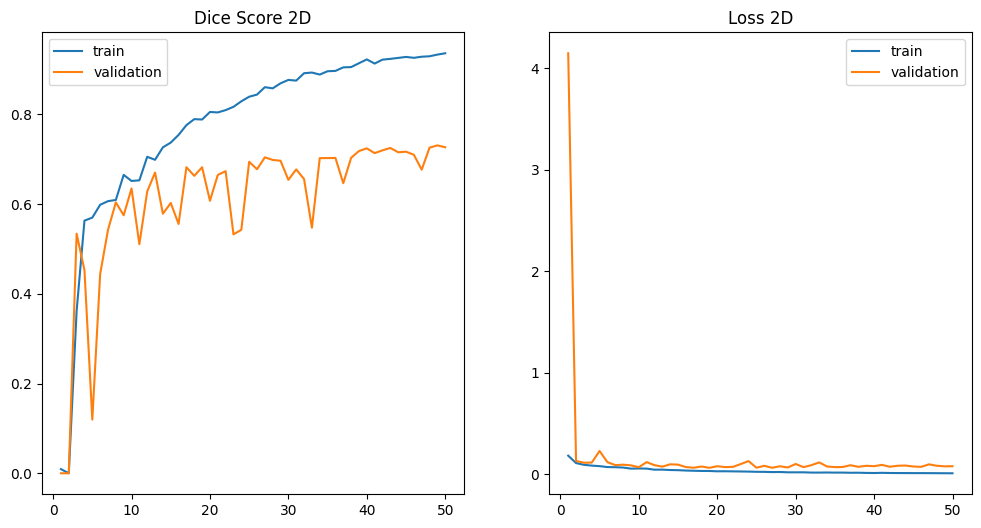

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# UNet 2D
axs[0].plot(np.linspace(1, epochs, epochs), dice_hist["train"], label="train")
axs[0].plot(np.linspace(1, epochs, epochs), dice_hist["val"], label="validation")
axs[1].plot(np.linspace(1, epochs, epochs), loss_hist["train"], label="train")
axs[1].plot(np.linspace(1, epochs, epochs), loss_hist["val"], label="validation")

axs[0].legend()
axs[1].legend()
axs[0].title.set_text('Dice Score 2D')
axs[1].title.set_text('Loss 2D')
plt.show()

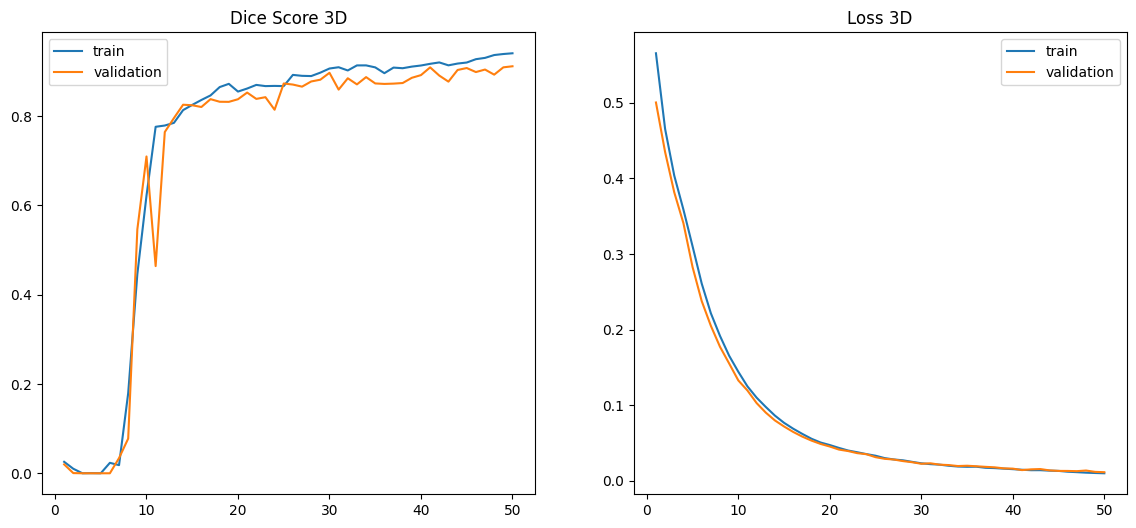

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# UNet 3D
axs[0].plot(np.linspace(1, epochs, epochs), dice_hist_3d["train"], label="train")
axs[0].plot(np.linspace(1, epochs, epochs), dice_hist_3d["val"], label="validation")
axs[1].plot(np.linspace(1, epochs, epochs), loss_hist_3d["train"], label="train")
axs[1].plot(np.linspace(1, epochs, epochs), loss_hist_3d["val"], label="validation")

axs[0].legend()
axs[1].legend()
axs[0].title.set_text('Dice Score 3D')
axs[1].title.set_text('Loss 3D')
plt.show()

As we can see above, 3D Model has better results compare to 2D. Training phase on 3D Model takes much longer but have smoother loss curve. My guess for better Dice score in 3D Model is that we are having neighboring slices that can help model to decide label each pixel with help of it's neighboring slices.

In [ ]:
model2D = UNet2D(in_channels=1, out_channels=1)
model2D.load_state_dict(torch.load('/content/drive/MyDrive/CurrentData/Seg2D.pt'))
# , map_location=torch.device('cpu') ))
model2D.to(device)

model3D = UNet3D(in_channels=1, out_channels=1)
model3D.load_state_dict(torch.load('/content/drive/MyDrive/CurrentData/Seg3D_v2.pt'))
# , map_location=torch.device('cpu') ))
model3D.to(device)

In [ ]:
available_masks = []
for i in range(valid_Y.shape[0]):
  for j in range(valid_Y.shape[1]):
    mask = valid_Y[i, j, :, :]
    if mask.sum() > 300:
      available_masks.append((i, j))

selected = np.random.randint(0, len(available_masks), 3)

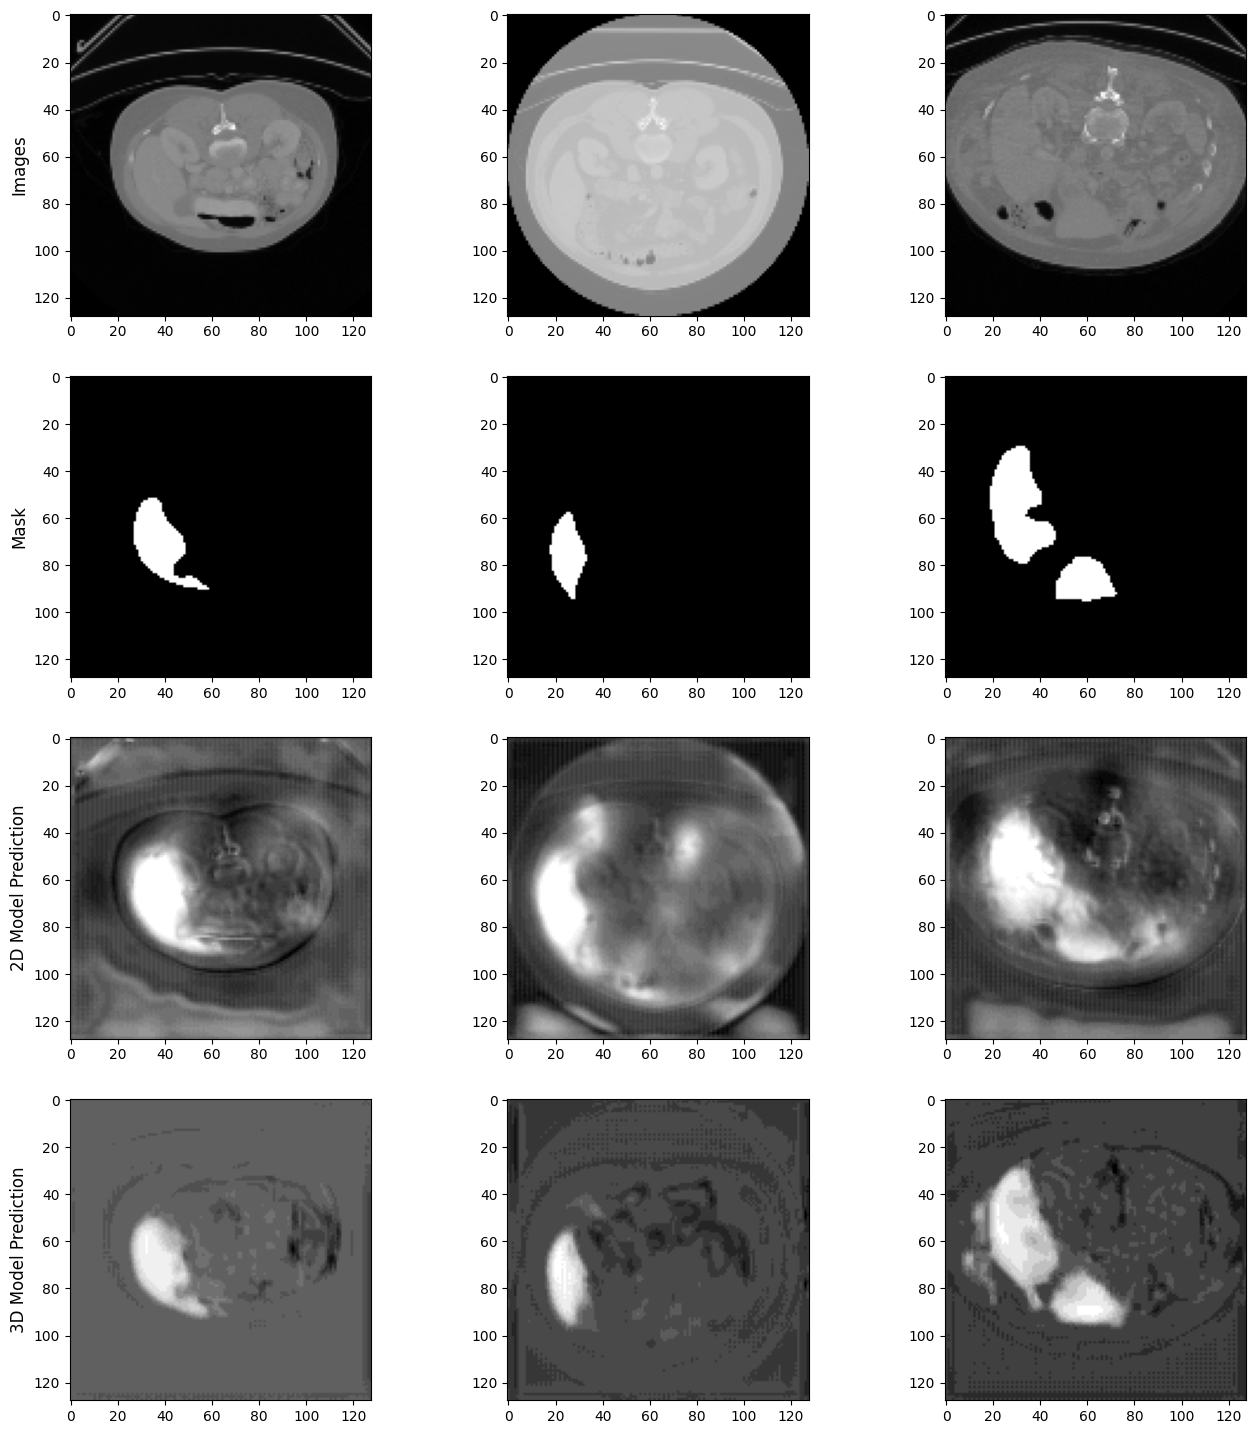

In [90]:
fig, axs = plt.subplots(4, 3, figsize=(16, 18))

for i, sel in enumerate(selected):
  x_2d = valid_X[available_masks[selected[i]][0], available_masks[selected[i]][1], :, :]
  x_3d = valid_X[available_masks[selected[i]][0], :, :, :]
  y = valid_Y[available_masks[selected[i]][0], available_masks[selected[i]][1], :, :]
  axs[0][i].imshow(x_2d, cmap='gray')
  axs[1][i].imshow(y, cmap='gray')
  x_2d = torch.from_numpy(x_2d).to(device)
  x_3d = torch.from_numpy(x_3d).to(device)
  x_2d = x_2d.unsqueeze(0).unsqueeze(0)
  with torch.no_grad():
    y_pred_2d = model2D(x_2d).squeeze(0).squeeze(0).round()
  x_3d = x_3d.unsqueeze(0).unsqueeze(0)
  with torch.no_grad():
    y_pred_3d = model3D(x_3d).squeeze(0).squeeze(0).round()
  axs[2][i].imshow(y_pred_2d.cpu().detach().numpy(), cmap='gray')
  axs[3][i].imshow(y_pred_3d[available_masks[selected[i]][1], :, :].cpu().detach().numpy(), cmap='gray')

for ax, row in zip(axs[:,0], ['Images', 'Mask', '2D Model Prediction', '3D Model Prediction']):
    ax.set_ylabel(row, rotation=90, size='large')

plt.show()

Again we can see 3D Model segment better based on ground truth data.